#  **<center>Data Wrangling** 

#### **Data Loading**

In [2]:
# Import all the Necessary Packages
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tqdm import tqdm

plt.style.use('dark_background')

#### **Set Directory**

In [2]:
# Find and set the working directory for this project
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

#### **Load the Data**

In [3]:
# Import the data and see what it looks like
data = pd.read_csv(r'./data/raw/kddcup.data_10_percent')
data.head()

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


The dataset and column names can be found in the about section on the data's webpage: [KDD Dataset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The initial dataset that I worked with was only 10% of the total dataset and does not include the special test set with different attack types. My computer is only so strong so at first I will create a model with the first 10% and if my algorithms are efficient enough to give me the time to try the whole dataset then I will try that as well.

In [4]:
# I copy and pasted the column names from the website into this list
data.columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                "num_failed_logins", "logged_in", "num_compromised",
                "root_shell", "su_attempted", "num_root", "num_file_creations",
                "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate",
                "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.


Below I separated the data into the feature variables (X). With X I can use pandas dummy creator method to create dummy features for all the unique values in the categorical columns. This will make it possible to analyze the entire dataset for multicollinearity instead of just the numerical columns.  

In [49]:
# Only use the X data so that it is easy to test for multicollinearity
X_data = data.drop('labels', axis = 1)

# Find the categorical columns that need to be made numerical for analysis
cat_cols = list(X_data.select_dtypes(include = 'object').columns)

# Creating a completely numerical dataset that is usable for analysis
x_num_data = pd.get_dummies(X_data, columns = cat_cols, 
                        # When testing for multi-co-linearity it is important to drop one of the dummies
                        # so that that column doesn't get flagged
                            drop_first = True)

#### **First Look**

The easiest way to get a grasp of the dataset is to use the function "ProfileReport." ProfileReport is a function from the y-data profiling package that takes a dataset and performs all of the starting analyses that reveal problems to clean up, or avenues to explore. I did not run this function in the uploaded version because the report was so large that it required me to store the entire notebook in git lfs storage. 

In [ ]:
# Report exploring all of the variables in the data
# Dark Mode is enabled for my eyes
profile = ProfileReport(data, 
                        title = 'Network Intrusion Exploration',
                        dark_mode = True)
profile

This report has a lot of important information:

-  No missing values: This is a really nice part about this dataset that there are no missing values. Because this is dataset on computer networks run by MIT Lincoln labs it is not surprising that the data is this high quality but nonetheless with the amount of data in the dataset having no missing values is impressive.
-  Constant features: Features that are constants are useless as they give no information to any model that we could use. They may contain some information in the entirety of the dataset, but they were constant in this 10% sub-section.
-  Skewed features: To fix this we can scale the data so that only the trends in the data will be captured by the model and not arbitrarily high numbers.
-  High numbers of zeros: This will be addressed in feature selection. We can run tests such as lasso regularization to determine which features have an impact on the target variable. If a feature with a large number of zeros has a large impact, then the number of zeros doesn't matter and if there is no impact then we can drop the feature. 
-  Large Multicollinearity: This is a major problem that I will take most of the notebook to address. Multicollinear predictions can be unreliable, and it is impossible to isolate which feature is causing the target variable's behavior.

**Constant Features**

Both "num_outbound_cmds" and "is_host_login" have a constant value so they can be dropped. This step may be changed if I use the entire dataset.

In [48]:
# Use the drop methods to get rid of the constants
data = data.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1)

**Skewed Features**

Skewed features are a problem as they make it hard for models to accurately describe interactions between atypical features because the arbitrary size of some features will warp the math to obscure the correlations. To fix this I scaled the features with a standard scaler to preserve the patterns of each feature while eliminating the large values.

In [50]:
# Create the scaler object
scaler = StandardScaler()
# fit the scaler to the dataset
scaler.fit(x_num_data)
# Scale the dataset
x_num_data_scaled = pd.DataFrame(scaler.transform(x_num_data), columns = x_num_data.columns)

Store the features and target dataframes as X and y so that it is easy to code for the rest of the notebook.

In [51]:
# Define X as all the feature variables in numerical form scaled
X = x_num_data_scaled
# Define y as a binary target variable where 0 is no attack and 1 is an attack
y = np.where(data['labels'] == 'normal.', 0, 1)

## <center>**Multicollinearity**

The most glaring problem from “ProfileReport” is the number of variables that have high correlations with each other. This is because a sizable portion of the columns measure similar things. For instance, "srv_rerror_rate" and "dst_host_srv_rerror_rate” both measure the rate at which a server will deny a connection request. The former is recording only the last two seconds whereas the latter is using the last hundred connections. While both features have slightly different information, the information is so similar that it is impossible to leave both features in the dataset. The challenge now is to go through the dataset and try to find all instances of similar features and either combine them or discard them.

For the heatmaps below I defined a function that would whichever heatmap I needed. I graphed the absolute value of the correlations because a negative correlation in multicollinearity is just as bad as a positive correlation. 

In [74]:
# Function to get rid of all the diagonals in correlation heatmaps
def zero_diagonal_heatmap(dfx, min = 0, max = None, color_map = None, threshhold = 0):
    # give the max a base value
    if max is None:
        max = len(dfx)
    # Create a numpy matrix that is easy to manipulate
    cm = np.matrix(abs(dfx.iloc[:,min:max].corr()))
    # Create a loop that replaces all the diagonal values with 0
    for i in range(len(cm)):
        # Loop thorough the other axis of values
        for j in range(len(cm)):
            # All diagonal values happen when i == j
            if i == j:
                # set the diagonal value equal to 0
                cm[i,j] = 0
    df_cm = pd.DataFrame(cm, columns = list(dfx.columns)[min:max], index = list(dfx.columns)[min:max])
    # Make the plot bigger
    plt.figure(figsize=(12, 8))
    # Plot the heatmap
    ax = sns.heatmap(df_cm, cmap = color_map, center = threshhold, vmin = 0, vmax = 1);

Below is the starting point on how correlated the features are to themselves when every feature is numeric. It is not as extreme as the graph inside the profiling report because most of those features are dummy variables from the categorical columns. Because I dropped the first value of those columns, it is mathematically impossible for those dummy columns to be collinear. 

The brighter the square, the higher the collinearity. The numbers represent which number feature is being shown.

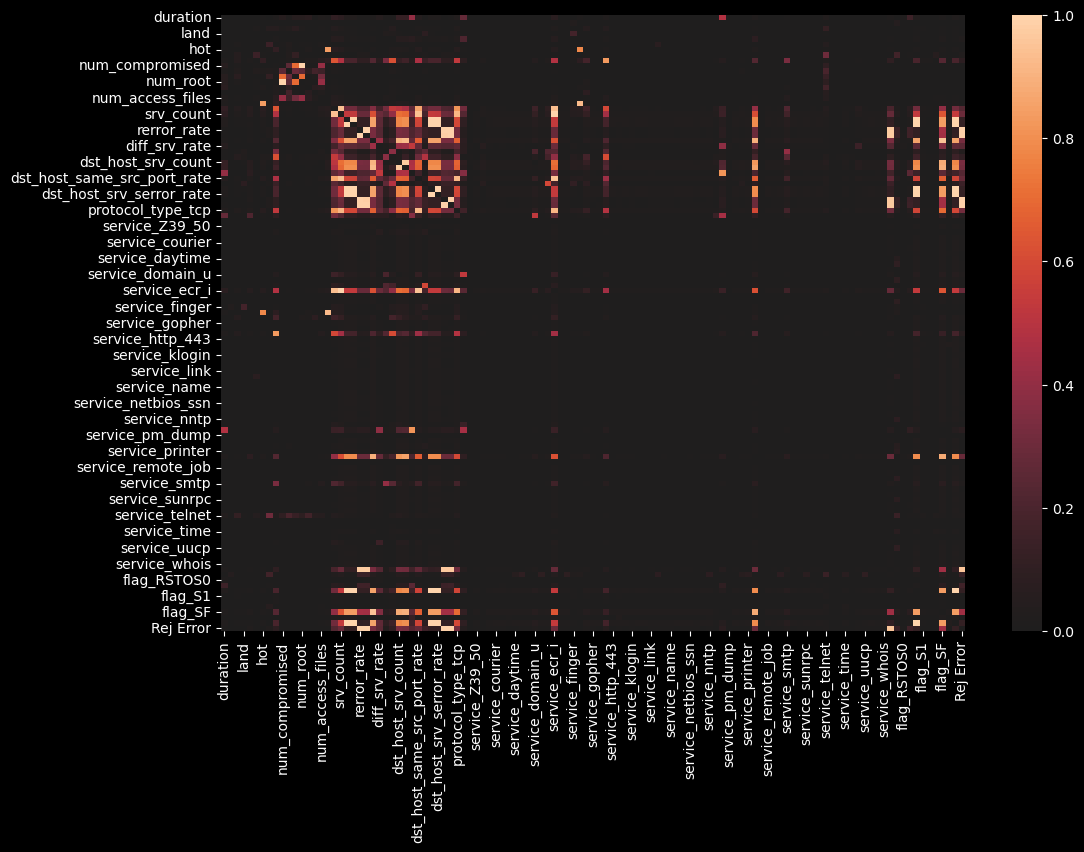

In [75]:
zero_diagonal_heatmap(X)

The heatmap shows a concerning square from features 15 to 39. While there are other problem areas, if I can clean up that square, many of the other collinearities will dissipate.

Cleaning up the collinearity is not easy. While it may seem tempting to drop all the problematic columns, there is too much important information that is contained within those columns. Most of the heatmap that has no correlation are dummy variables that are iterations of the same variable and contain less information. 

The first attempt that I made was look at the features in the dataset and see if there were clear groups of features that had clear real world explanations for their high correlations. This was too hard as I am not familiar with this subject matter and the amount of groupings felt endless. Next I decided to zoom in on bright spot of the heatmap to see if there were any obvious groupings. 

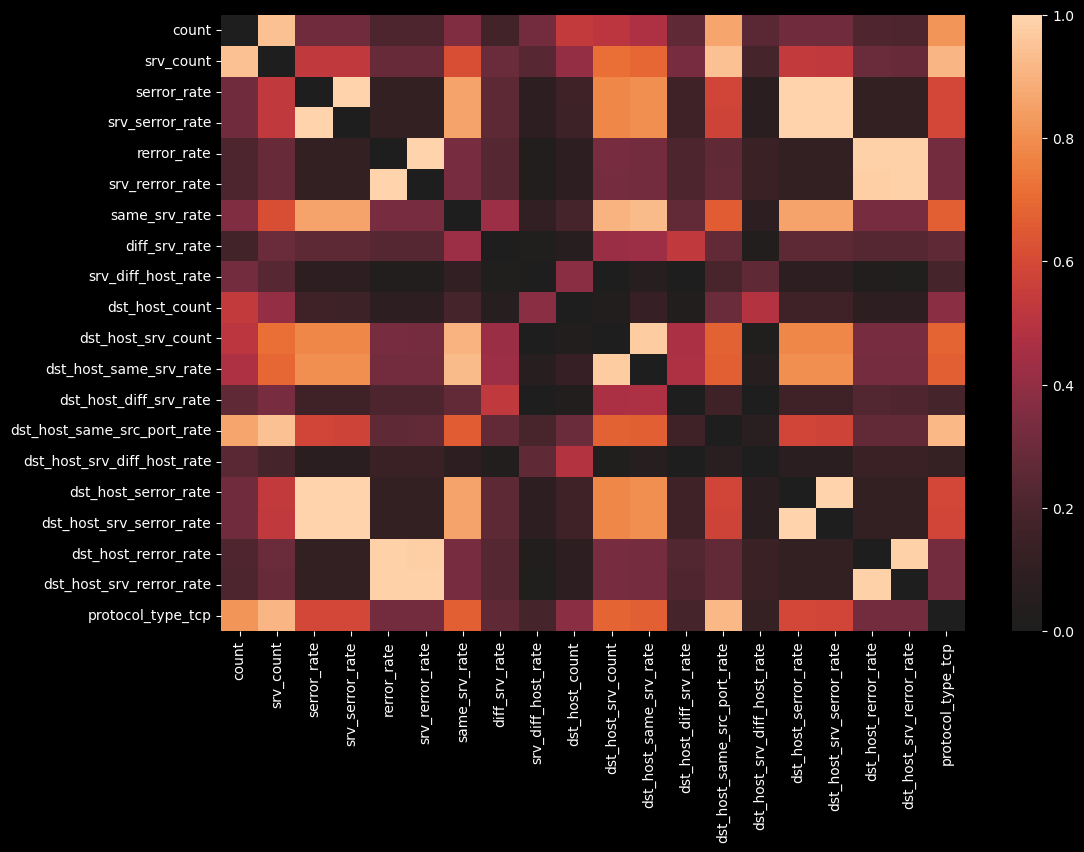

In [82]:
zero_diagonal_heatmap(dfx = X, min = 17, max = 37);

In the heatmap above “serror” or “rerror” account for four variables each that create boxes of prominent levels of correlation. Given their clear real-world connection, I combined each grouping of the four variables into ‘Syn Error’ and ‘Rej Error’ by taking the maximum value of those four variables for each observation. That way if there is a spike in one of the four variables, then Syn and Rej Error will spike while if all four of the original variables are low, then the combined feature will be low as well. 

In [52]:
# Define the Syn Error columns
serror = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

# Define the Syn Error columns
rerror = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

# Drop the redundant columns
df = x_num_data_scaled.drop(columns = [*serror, *rerror])

# Create new Syn Error column as mean of the former Syn Error columns
df['Syn Error'] = X[serror].max(axis = 1)


# Create new Syn Error column as mean of the former Syn Error columns
df['Rej Error'] = X[rerror].max(axis = 1)

Nothing else was obvious from the heatmap above so I created a function that produces dictionary with the features as keys and the number of correlations with other features over 0.7 as the values.

In [10]:
# Create a function that takes a dataframe and a correlation level 
def corr_dict(dfx, corr = 0.7):
    # Create the correlation with absolute values to measure collinearity
    corr_mat = abs(dfx.corr()) > corr   # type: ignore
    # Define the dictionary outside the function for uses
    global correl_dict
    # Create a dictionary with sorted values so that it is easy to see the next steps
    correl_dict = dict(corr_mat.sum().sort_values(ascending = False)) 
    # Subtract each value by one for the self correlation on the diagonal
    correl_dict = {key: value - 1 for key, value in correl_dict.items() if value != 1}
    # Print the dictionary
    print(correl_dict)

With this function we can plug in the dataframe df and see what it is that we are supposed to do next.

In [40]:
corr_dict(df)

{'dst_host_srv_count': 8, 'Syn Error': 6, 'flag_SF': 6, 'service_private': 6, 'same_srv_rate': 6, 'dst_host_same_srv_rate': 6, 'flag_S0': 6, 'srv_count': 5, 'service_ecr_i': 5, 'protocol_type_tcp': 4, 'count': 4, 'dst_host_same_src_port_rate': 4, 'service_ftp': 2, 'is_guest_login': 2, 'num_compromised': 2, 'hot': 2, 'flag_REJ': 1, 'dst_host_diff_srv_rate': 1, 'Rej Error': 1, 'service_other': 1, 'num_root': 1, 'su_attempted': 1, 'logged_in': 1, 'service_http': 1}


This dictionary has a ton of features that would be hard to evaluate individually. Instead I can clean the features that have four or more collinearities to clean up the features faster. I also want to omit 'Syn Error' from this process until I need to because it is a representation of four different features.

The next heatmap is a binary color scheme where white is above a correlation threshhold. I picked 0.9 to start with so that I can deal with the obvious cases.

In order to see how effective reducing the most multicollinear features are I can create a function that produces a dictionary that has each feature and a list of features that they are collinear with.

In [52]:
# Create a function that takes a list of features and minimum number of correlations
def corr_list(min_corr, corr, still_high_mcl = None):
    # Define the dictionary where all the information will be stored
    correlations2 = {}
    # Almost always the default value will be None
    if still_high_mcl is None:
        # # the default list is the keys from correl_dict whose values are at least min_corr
        still_high_mcl = [key for key, value in correl_dict.items() if value >= min_corr]
    # Store the correlation matrix in a variable for easy use  
    still_corr = abs(df[still_high_mcl].corr())
    # Put the index and column names as the feature names
    still_corr.columns = still_high_mcl
    still_corr.index = still_high_mcl
    # Iterate through all the features in the list
    for shm in still_high_mcl:
        # create a list of all the features that have a correlation of over 7
        corrs2 = still_corr.index[still_corr[shm] > corr].tolist() #type: ignore
        # remove the self correlation
        corrs2.remove(shm)
        # input the feature and list into the dictionary
        correlations2.update({shm: corrs2})
    # print the result    
    print(correlations2)

Now we can run the corr_list function with min_corr =4

In [41]:
corr_list(corr = .7, min_corr = 4)

{'dst_host_srv_count': ['Syn Error', 'flag_SF', 'service_private', 'same_srv_rate', 'dst_host_same_srv_rate', 'flag_S0', 'srv_count', 'service_ecr_i'], 'Syn Error': ['dst_host_srv_count', 'flag_SF', 'service_private', 'same_srv_rate', 'dst_host_same_srv_rate', 'flag_S0'], 'flag_SF': ['dst_host_srv_count', 'Syn Error', 'service_private', 'same_srv_rate', 'dst_host_same_srv_rate', 'flag_S0'], 'service_private': ['dst_host_srv_count', 'Syn Error', 'flag_SF', 'same_srv_rate', 'dst_host_same_srv_rate', 'flag_S0'], 'same_srv_rate': ['dst_host_srv_count', 'Syn Error', 'flag_SF', 'service_private', 'dst_host_same_srv_rate', 'flag_S0'], 'dst_host_same_srv_rate': ['dst_host_srv_count', 'Syn Error', 'flag_SF', 'service_private', 'same_srv_rate', 'flag_S0'], 'flag_S0': ['dst_host_srv_count', 'Syn Error', 'flag_SF', 'service_private', 'same_srv_rate', 'dst_host_same_srv_rate'], 'srv_count': ['dst_host_srv_count', 'service_ecr_i', 'protocol_type_tcp', 'count', 'dst_host_same_src_port_rate'], 'servic

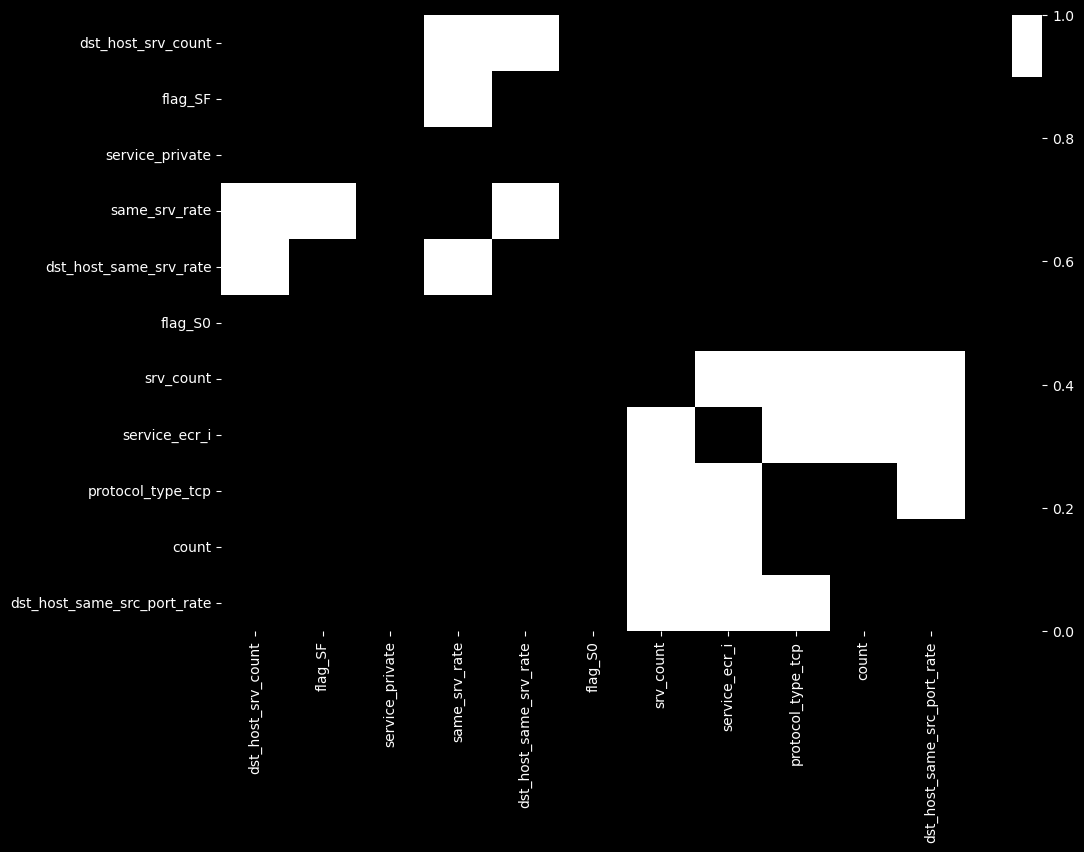

In [123]:
# Get all the features from the dictionary in the previous cell
left = [key for key, value in correl_dict.items() if value >= 4]
# remove Syn Error till it is urgent
left.remove('Syn Error')

# Define the dataframe X_left which has every feature with 5 or more collinearities
df_left = df[left]
# Create a heatmap of all the features that left
zero_diagonal_heatmap(df_left, color_map = ListedColormap(['black', 'white']), threshhold = 0.9) #type: ignore

From here we can see that there are two groupings of features that can be combined or eliminated. 
-  Top left: ['dst_host_srv_count', 'same_srv_rate', 'dst_host_same_srv_rate'] 
-  Bottom right corner: ['srv_count','service_ecr_i', 'dst_host_same_src_port_rate']

The top left group should be combined because the variables in it are measuring connections to the same server in different ways. Similar to the Syn and Rej error I will take the max of 'same_srv_rate', 'dst_host_same_srv_rate'. Since there is no way to combine 'dst_host_srv_count' and it is highly collinear I will drop it. 

For the bottom right there is no clear thread tying the three together. I decided to keep 'protocol_type_tcp' because the other two have a massive correlations with count. If I keep 'protocol_type_tcp' then I can keep 'count'

In [54]:
# Drop These columns that have no clear connection but are multicollinear
df = df.drop(['srv_count','service_ecr_i', 'dst_host_same_src_port_rate'],axis = 1)

# Drop the non-rate column
df = df.drop('dst_host_srv_count', axis = 1)

# Create the srv_rate column
srvrate = ['dst_host_same_srv_rate', 'same_srv_rate']

# Define srvrate
df['srv_rate'] = df[srvrate].max(axis = 1)

# Drop the srvrate columns
df = df.drop(srvrate, axis = 1)

While I have eliminated a lot of bad features, I still have a lot to go. I can use the same corr_dict function to see what features are left.

In [43]:
# Find the worst multicollinear offenders.
corr_dict(df)

{'srv_rate': 4, 'flag_S0': 4, 'Syn Error': 4, 'service_private': 4, 'flag_SF': 4, 'service_ftp': 2, 'hot': 2, 'num_compromised': 2, 'is_guest_login': 2, 'service_http': 1, 'protocol_type_tcp': 1, 'dst_host_diff_srv_rate': 1, 'flag_REJ': 1, 'service_other': 1, 'count': 1, 'su_attempted': 1, 'Rej Error': 1, 'logged_in': 1, 'num_root': 1}


Unfortunately the some of the highest numbers are from the features that I created. I can use the corr_list function to see if what each of these features are correlated with.

In [45]:
corr_list(min_corr = 4, corr = 0.7)

{'srv_rate': ['flag_S0', 'Syn Error', 'service_private', 'flag_SF'], 'flag_S0': ['srv_rate', 'Syn Error', 'service_private', 'flag_SF'], 'Syn Error': ['srv_rate', 'flag_S0', 'service_private', 'flag_SF'], 'service_private': ['srv_rate', 'flag_S0', 'Syn Error', 'flag_SF'], 'flag_SF': ['srv_rate', 'flag_S0', 'Syn Error', 'service_private']}


The goal here is to preserve the most amount of information possible. The order of column importance is defined as:
1)	Combinations of Original Columns:
    -  	‘Syn Error’, ‘Rej Error’, ‘srv_rate'
2)	Numerical Original Columns
    -  	‘count’, ‘src_bytes’
3)	Binary Original Columns
    -  	‘su_attempted’, ‘is_guest_login’
4)	Dummy Variables from the Categorical Variables
    -  	'protocol_type_tcp', ‘flag_SF’

If I obtain terrible results on my training scores during the model section I will think about selecting different features. Although multicollinearity makes it hard to be very wrong on which variables not to take.

Here I dropped all the dummy variables and binary variables from the list. 

In [56]:
# Drop these features as well for MCL and they aren't as good as their collinearities
df = df.drop(['flag_S0', 'flag_REJ', 'flag_SF', 'service_private','service_ftp','num_root',
              'srv_rate', 'service_http','protocol_type_tcp', 'is_guest_login','service_other',
              'su_attempted'], axis = 1)

Find how many are still left with corr_dict

In [49]:
corr_dict(df, corr = .6)

{'logged_in': 2, 'dst_host_count': 1, 'count': 1}


While it is clear that they are all correlated with each other, it is easier to visualize the groupings with corr_list 

In [53]:
corr_list(min_corr = 1, corr = 0.6)

{'logged_in': ['dst_host_count', 'count'], 'dst_host_count': ['logged_in'], 'count': ['logged_in']}


Here I decided to drop 'logged_in as it is a binary variable while the other two are not.

In [58]:
# The vif score was too high so I had to see if dropping it would give a better chance
df = df.drop(['logged_in'], axis = 1)

Now it is time to see the progress that has been made. I can call another heatmap on the dataset and see how much darker it is because of the decrease in multicollinearity.

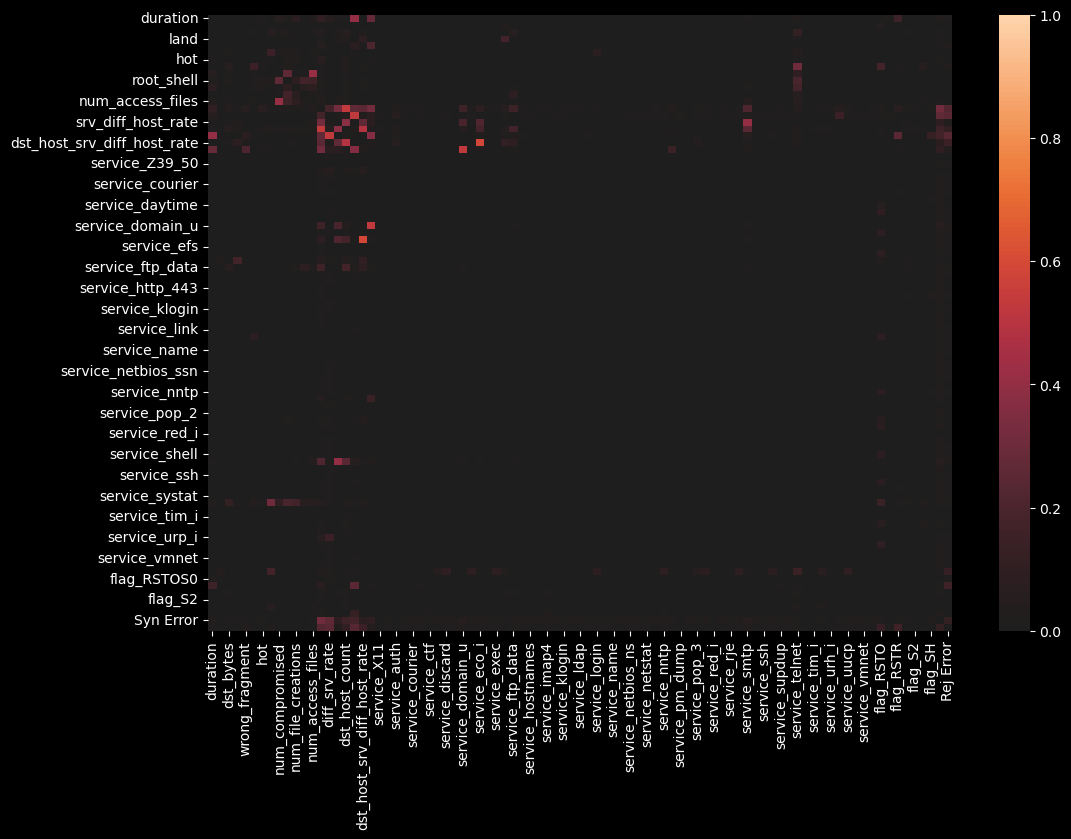

In [55]:
zero_diagonal_heatmap(df);

To make sure that I had fully eliminated the multicollinearity I calculated every remaining feature’s Variance Inflation Factor (VIF). The formula for VIF is:
$$VIF=\frac{1}{1-R^2}$$                                                  
Where ${R^2}$ is the R-squared value that represents correlations.   

In [79]:
# Create vif function with a dataframe as the argument
def vif(dfx):
    #calculate the vif for the dataframe to see if it is non collinear
    vifs = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
    # Put those numbers into a dictionary
    vif_dict = {dfx.columns[i]:vifs[i] for i in range(dfx.shape[1])}
    # Create a filtered dictionary to find out how many features have a VIF under 2.5
    filtered_dict = {k: v for k, v in vif_dict.items() if v < 2.5}
    # Print the amount of columns that aren't collinear out of all the columns
    print(f"{len(filtered_dict)} out of {len(dfx.columns)} features have a vif < 2.5")
    # Create a sorted dictionary based on the values
    vif_dict = {k:v for k, v in sorted(vif_dict.items(), key=lambda item: item[1], reverse = True)}
    # Print the result
    print(vif_dict)

In [65]:
# Run the variance_inflation_factor function
vif(df)

87 out of 89 features have a vif < 2.5
{'count': 3.0203968236684817, 'protocol_type_udp': 2.764759613168448, 'dst_host_count': 2.485347692724259, 'dst_host_diff_srv_rate': 2.446428279013481, 'dst_host_srv_diff_host_rate': 2.1860958659267107, 'Syn Error': 1.940440598832916, 'diff_srv_rate': 1.708529939565954, 'service_domain_u': 1.6806702052617033, 'service_eco_i': 1.661731401280234, 'srv_diff_host_rate': 1.4909846405717229, 'Rej Error': 1.4639136048684047, 'duration': 1.3290269998933069, 'service_smtp': 1.3195298198246417, 'num_compromised': 1.2765500844197495, 'num_access_files': 1.2234332422618908, 'service_telnet': 1.203954031762308, 'flag_RSTR': 1.1597316915869866, 'flag_RSTO': 1.159201136014101, 'num_failed_logins': 1.1518817801684689, 'root_shell': 1.1438291476459763, 'wrong_fragment': 1.0874433057682926, 'service_ftp_data': 1.0840514730725233, 'service_finger': 1.0543150483631125, 'num_file_creations': 1.0522718748196689, 'service_urp_i': 1.0520660582496837, 'num_shells': 1.0429

The guidelines for an acceptable VIF score can range from 2.5-10 although anything over five is suspicious. The remaining features appear to have acceptable levels of multicollinearity

## <center> **Lasso Regularization**

Lasso Regularization is a technique for variable selection that uses regression to evaluate the effect that features have on a target variable. The idea is to add a penalty term that contains the coefficient or slope of the variables with respect to the target variable multiplied by parameter. 
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha|β| \nonumber
\end{equation}
Where $\beta$ is the coefficient of the feature, SSD is the sum of squared distances of the point to the regression line and $\alpha$ is the penalty’s parameter. If there is more than a single feature, then we can sum the coefficients:
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha* \sum_{i=1}^{n}|β_i| \nonumber
\end{equation}
Lasso aims to reduce the loss in equation (3). If a feature is not important, then changing its slope will not move the regression line close enough to the data points to decrease the loss function with a non-zero value. If a feature is important, the regression line will move towards the data and minimize the SSD faster than it increases the penalty term. Since only features with non-zero coefficients are meaningful, I can discard all the features with a coefficient of zero. 



First we will run a gridsearch to find the best value of $\alpha$, and then we will use the coeffecients from that value of $\alpha$ to determine which features stay in the model.

In [64]:
# Create Lasso model
lasso = Lasso(max_iter = 50000)

# Define hyperparameter grid with a value less than 00.5 since that was the be
params = {'alpha': np.linspace(.001, .01, 20)}

# Perform grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, cv=8)

# fit the gridsearch of parameters to the data
grid_search.fit(df, y)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'alpha': 0.007157894736842105}


Now that we have the hyper parameter alpha we can conduct the lasso regularization

In [68]:
# Find the coefficients of lasso regularization
lasso = Lasso(alpha = 0.007157894736842105)
# Fit the lasso regularization to the data 
lasso.fit(df,y)
# Create a dictionary of all the features and their corresponding lasso coefficients
lasso_dict = {df.columns[i]:lasso.coef_[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0}
# Create a list of all the features that don't have a lasso coefficient of zero
lasso_features = [df.columns[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0]
# Print the features and coefficients
print(lasso_dict)
# Print the number of features are left from lasso
print(len(lasso_dict))

{'wrong_fragment': 0.02899951876972804, 'hot': 0.018796473321138842, 'count': 0.34090278151161835, 'srv_diff_host_rate': -0.00109589698087162, 'dst_host_count': 0.05249016759404078, 'protocol_type_udp': -0.02584332221195196, 'service_eco_i': 0.036867214236286854, 'service_ftp_data': 0.0012073668145983483, 'service_smtp': -0.0037673387422819306, 'flag_RSTR': 0.010856067241035963, 'Syn Error': 0.18961134836567742, 'Rej Error': 0.08588313388201708}
12


Now I can create the new dataframe by using all of the keys of the dictionary as the column names.

In [89]:
# Generate the dataframe with only the non zero lasso coefficients
small_df = df[list(lasso_dict.keys())]
# Take a look at the dataset
small_df.head()

,wrong_fragment,hot,count,srv_diff_host_rate,dst_host_count,protocol_type_udp,service_eco_i,service_ftp_data,service_smtp,flag_RSTR,Syn Error,Rej Error
0,-0.04772,-0.044136,-1.521422,-0.203633,-3.297128,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961
1,-0.04772,-0.044136,-1.521422,-0.203633,-3.142675,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961
2,-0.04772,-0.044136,-1.530805,-0.203633,-2.988222,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961
3,-0.04772,-0.044136,-1.530805,-0.203633,-2.833769,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961
4,-0.04772,-0.044136,-1.530805,-0.203633,-2.679316,-0.207295,-0.057748,-0.098227,-0.141692,-0.042793,-0.463203,-0.247961


One last check on small_df's collinearity:

In [72]:
# Check the vif score for all of small_df's features
vif(small_df)

11 out of 12 features have a vif < 2.5
{'count': 2.8876896953781785, 'dst_host_count': 2.0342537333699258, 'Syn Error': 1.6866014700960554, 'protocol_type_udp': 1.4749448631864086, 'srv_diff_host_rate': 1.4220767753935735, 'service_smtp': 1.274684999333189, 'Rej Error': 1.2128018726881336, 'service_eco_i': 1.0789581056639406, 'service_ftp_data': 1.0645413687724392, 'wrong_fragment': 1.0496898576816533, 'flag_RSTR': 1.0322536483111362, 'hot': 1.0149909763208826}


'count' may be slightly elevated but is still within an acceptable range for a vif score. I can also use the zero_diagonal_heatmap function to visualize multicollinearity.

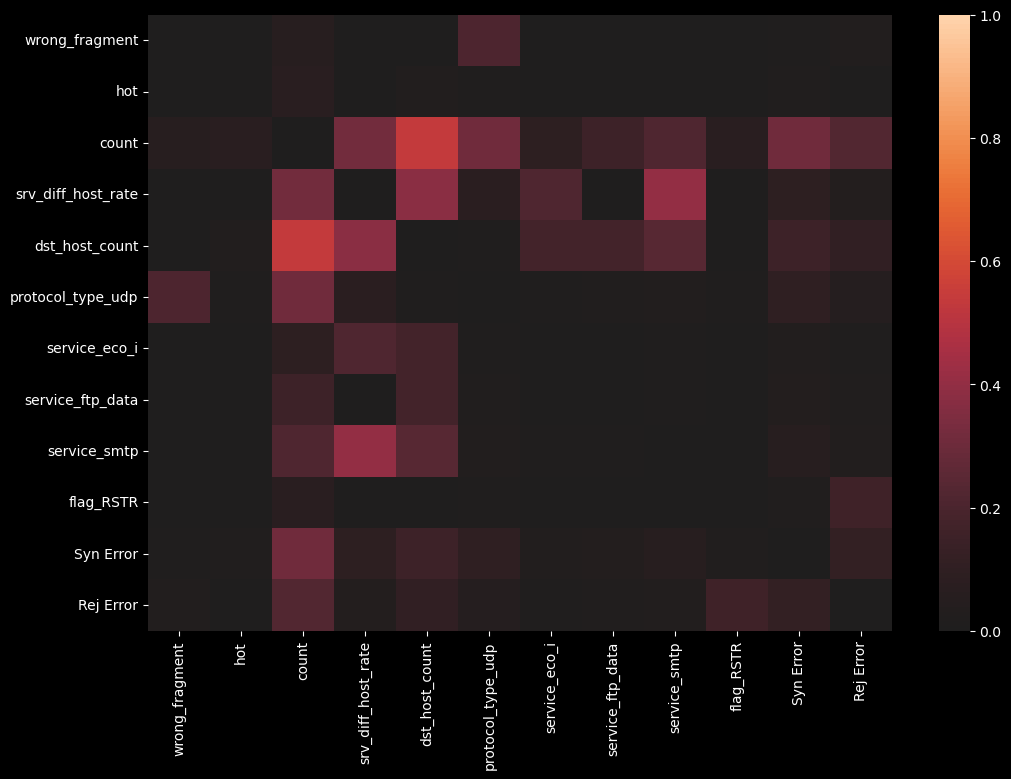

In [76]:
# Visualize collinearity for small_df's features
zero_diagonal_heatmap(small_df)

We now have the 12 most important features in the dataset. This will make data exploration and running models significantly easier. Since the current data that I am working with is only 10 percent of the entire dataset I may be able to run models on the full dataset in a reasonable amount of time. Now we can save the dataset that just has the lasso features.

But the 12 features do not encompass all of the features that can differentiate between intrusion types. To do this we can perform iterate through all the different attack types using lasso regularization to see what other features are helpful in differentiating the attack types.

In [70]:
# import data to the script
df_y = pd.concat([df, data['labels']], axis = 1)

# Initialize features list
relevent_features = []
# Iterate over all the types of intrusions 
for i, label_i in tqdm(enumerate(df_y['labels'].unique())):
    # Iterate over a different intrusion
    for j, label_j in enumerate(df_y['labels'].unique()):
        if i < j:
            # Take only the data that has smurf or neptune
            blue_data = df_y.loc[df_y['labels'].isin([label_i, label_j])]
            # Grab only the features
            x_blue = blue_data.drop('labels', axis = 1)
            # create y that is 0 for smurf and 1 for neptune
            y_diff_attacks = np.where(blue_data['labels'] == label_i, 0, 1)

            # Lasso would not converge and it would take too long to use gridsearch
            # most of the time alpha values were from .001 to .002
            lasso = Lasso(alpha = 0.007157894736842105, max_iter = 300000)

            # Fit the lasso regularization to the data 
            lasso.fit(x_blue, y_diff_attacks)

            # Create a dictionary of all the features and their corresponding lasso coefficients
            lasso_list = [df.columns[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0]

            relevent_features.extend(lasso_list)

23it [00:23,  1.03s/it]


Now we can see all of the relevant features by looking at the set of of the list relevant features

In [72]:
# Convert Relevant Features into a list with only unique values rf
rf = list(set(relevent_features))
# Select all of the rf columns from the df dataframe
big_df = df[rf]
# Take a look at big_df
big_df.head()

,service_netbios_ns,flag_RSTOS0,service_netstat,flag_SH,num_access_files,flag_S2,land,service_link,diff_srv_rate,service_X11,...,flag_RSTR,num_file_creations,service_domain_u,duration,num_compromised,service_rje,service_uucp,service_whois,service_imap4,num_shells
0,-0.014371,-0.004719,-0.013869,-0.014719,-0.027632,-0.00697,-0.006673,-0.014371,-0.255244,-0.004719,...,-0.042793,-0.011232,-0.109592,-0.067792,-0.005679,-0.014991,-0.01465,-0.014924,-0.015391,-0.009919
1,-0.014371,-0.004719,-0.013869,-0.014719,-0.027632,-0.00697,-0.006673,-0.014371,-0.255244,-0.004719,...,-0.042793,-0.011232,-0.109592,-0.067792,-0.005679,-0.014991,-0.01465,-0.014924,-0.015391,-0.009919
2,-0.014371,-0.004719,-0.013869,-0.014719,-0.027632,-0.00697,-0.006673,-0.014371,-0.255244,-0.004719,...,-0.042793,-0.011232,-0.109592,-0.067792,-0.005679,-0.014991,-0.01465,-0.014924,-0.015391,-0.009919
3,-0.014371,-0.004719,-0.013869,-0.014719,-0.027632,-0.00697,-0.006673,-0.014371,-0.255244,-0.004719,...,-0.042793,-0.011232,-0.109592,-0.067792,-0.005679,-0.014991,-0.01465,-0.014924,-0.015391,-0.009919
4,-0.014371,-0.004719,-0.013869,-0.014719,-0.027632,-0.00697,-0.006673,-0.014371,-0.255244,-0.004719,...,-0.042793,-0.011232,-0.109592,-0.067792,-0.005679,-0.014991,-0.01465,-0.014924,-0.015391,-0.009919


Check the vif for big_df's features.

In [80]:
vif(big_df)

59 out of 61 features have a vif < 2.5
{'count': 3.0131553563601647, 'protocol_type_udp': 2.6658172160755664, 'dst_host_count': 2.477525848892503, 'dst_host_diff_srv_rate': 2.4301565338491824, 'dst_host_srv_diff_host_rate': 2.1853393248277273, 'Syn Error': 1.9221554194078176, 'diff_srv_rate': 1.7067879730826272, 'service_eco_i': 1.6616348672759331, 'service_domain_u': 1.6547919180795394, 'srv_diff_host_rate': 1.4908996107208585, 'Rej Error': 1.459781142961954, 'duration': 1.3273494773104004, 'service_smtp': 1.3194172871856475, 'num_compromised': 1.276546072202618, 'num_access_files': 1.2234219879696158, 'service_telnet': 1.2033414456603033, 'flag_RSTR': 1.1580977781123258, 'num_failed_logins': 1.150985823410528, 'root_shell': 1.1438037754786659, 'flag_RSTO': 1.1165126133846912, 'wrong_fragment': 1.0843687977920209, 'service_ftp_data': 1.0839794467837738, 'service_finger': 1.0542238570818179, 'num_file_creations': 1.0522519970014679, 'service_urp_i': 1.052043870993215, 'num_shells': 1.0

Visualize the collinearity:

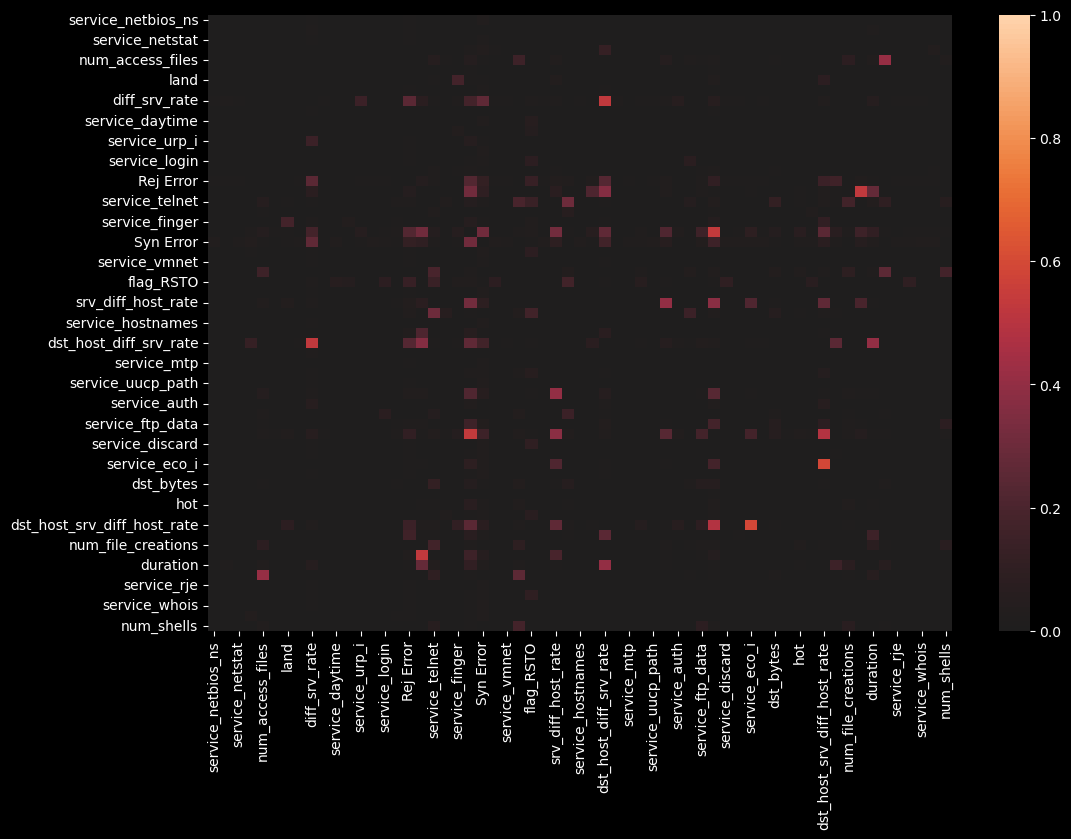

In [77]:
#Visualize the collinearity of big_df's features
zero_diagonal_heatmap(big_df)

#### **Save the New Data**

In [87]:
# Join the 12 features with the target variable
small_df = pd.concat([small_df, data['labels']], axis = 1)
# Save the data in a csv file
small_df.to_csv(r'./data/interim/Small_df.csv', index = False)

Save the big dataset with all the relevant features.

In [88]:
# Join the big dataset with the target variable
big_df = pd.concat([big_df, data['labels']], axis = 1)
# Save the data in a csv file
big_df.to_csv(r'./data/interim/Big_df.csv', index = False)